In [18]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [19]:
(x_train, _), (x_test, _) = mnist.load_data()
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of filters per CNN layer
layer_filters = [32, 64]

In [20]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first Conv2DTranspose
# will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


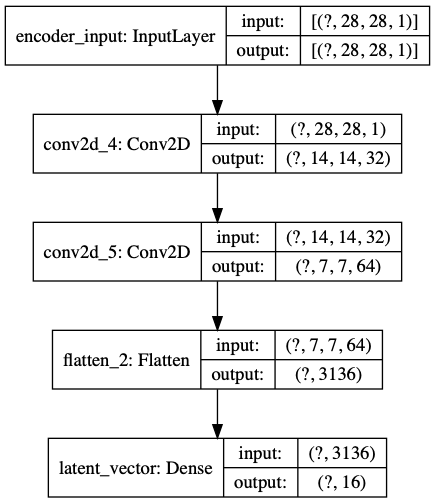

In [21]:
#plot_model(encoder, to_file='encoder.png', show_shapes=True)
plot_model(encoder, to_file='encoder.png', show_shapes=True)


In [22]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)

In [23]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
kernel_size=kernel_size,
activation='sigmoid',
padding='same',
name='decoder_output')(x)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

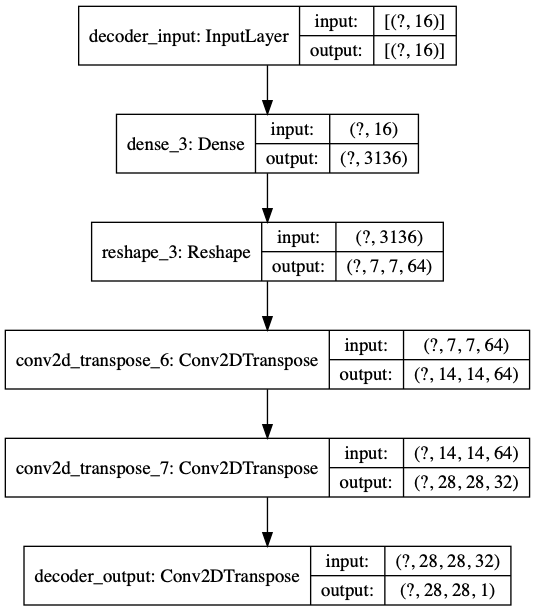

In [24]:
#plot_model(decoder, to_file='decoder.png', show_shapes=True)
plot_model(decoder,   show_shapes=True)

In [26]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


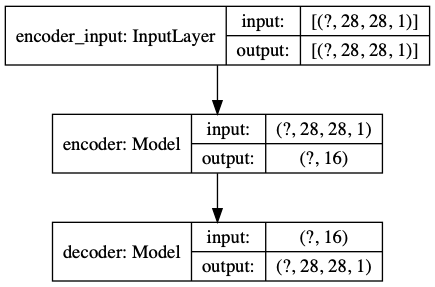

In [14]:
#plot_model(autoencoder,to_file='autoencoder.png',show_shapes=True)
plot_model(autoencoder,show_shapes=True)


In [15]:
# Mean Square Error (MSE) loss funtion, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')
# train the autoencoder
autoencoder.fit(x_train,x_train, validation_data=(x_test, x_test),epochs=1,batch_size=batch_size)
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

1875/1875 [==============================] - 47s 25ms/step - loss: 0.0119 - val_loss: 0.0095


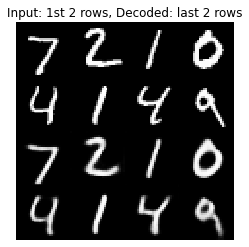

In [7]:
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()